In [3]:
#bibliotecas básicas para manipulção de dado.
import pandas as pd
import numpy as np

Realizo a leitura dos registros dos alunos evadidos da Escola de Minas. Dados retirados da UFOP, link no final do prgrama.

In [4]:
evadidos_1 = pd.read_csv('graduacao_evadidos.csv',sep=';', encoding='latin-1')
evadidos_2 = pd.read_csv('evadidos19_1.csv',sep=';', encoding='latin-1')
evadidos_3 = pd.read_csv('evadidos18_2.csv',sep=';', encoding='latin-1')
evadidos_4 = pd.read_csv('evadidos18_1.csv',sep=';', encoding='latin-1')

Tratamento dos bancos de dado:

In [5]:
#Unir os ultimos 3 periodos em um dataframe, todos continham cabeçalho identico.
evadidos_EM = pd.concat([evadidos_2, evadidos_3, evadidos_4], ignore_index=False, sort = False)

#Transformo a cabeçalho de todas as colunas em letra maiuscula e sem acento.
evadidos_1.columns = evadidos_1.columns.str.upper()
evadidos_EM.columns = evadidos_EM.columns.str.upper()
evadidos_EM = evadidos_EM.rename(columns={"UNIDADE ACADÊMICA": "UNIDADE_ACADEMICA","TIPO EVASÃO": "TIPO_EVASAO","ALUNOS": "EVADIDOS"})

#Junto o dataframe com todos os evadidos da EM
evadidos = pd.concat([evadidos_EM, evadidos_1], ignore_index=False, sort = False)

#Seleciono a Escola de Minas e limpo a coluna "CURSO"
evadidos = evadidos.loc[evadidos['UNIDADE_ACADEMICA'] == 'ESCOLA DE MINAS']
evadidos[['Resto','CURSO']] = (evadidos.CURSO.astype(str).str.split('-', expand = True))
evadidos = evadidos.drop(columns =["Resto"]) 
evadidos['TIPO_EVASAO'] = evadidos['TIPO_EVASAO'].replace('REOPÇÃO', 'REOPCAO')
evadidos['TIPO_EVASAO'] = evadidos.TIPO_EVASAO.str.replace('POR ', '')
evadidos.tail()

,ANO,SEMESTRE,CAMPUS,UNIDADE_ACADEMICA,CURSO,MODALIDADE,FORMATO,TIPO_EVASAO,EVADIDOS
3113,2017,2,OURO PRETO,ESCOLA DE MINAS,MEC,BACHARELADO,PRESENCIAL,DESLIGAMENTO,3
3114,2017,2,OURO PRETO,ESCOLA DE MINAS,MEC,BACHARELADO,PRESENCIAL,JUBILAMENTO,2
3115,2017,2,OURO PRETO,ESCOLA DE MINAS,MET,BACHARELADO,PRESENCIAL,CANCELAMENTO,32
3116,2017,2,OURO PRETO,ESCOLA DE MINAS,MET,BACHARELADO,PRESENCIAL,DESLIGAMENTO,9
3117,2017,2,OURO PRETO,ESCOLA DE MINAS,MET,BACHARELADO,PRESENCIAL,JUBILAMENTO,1


Com o número absoluto de evadidos em cada curso NÃO podemos comparar as disciplinas!! Para isso, temos que encontrar a TAXA DE EVASÃO, indicando quem mais evadiu proporcionalmente.

Vamos descobrir quantos matriculados cada curso tem ao longo to tempo.

In [6]:
#Matriculados na Escola de Minas
EM_total = pd.read_csv('emtotalordenado.csv',sep=';', encoding='latin-1')

#para agrupar pela data transformei os anos em variavel tipo data e somei os periodos.
EM_total['SemestreLetivo'] = pd.to_datetime(EM_total['SemestreLetivo'], format='%Y/%m')
matriculados = pd.DataFrame(EM_total.groupby(EM_total['SemestreLetivo'].dt.year).TotalGeral.sum())
matriculados.tail()

,TotalGeral
SemestreLetivo,
2015,6284
2016,6358
2017,6119
2018,6173
2019,3101


Agora com os bancos de dado de matriculados e evadidos podemos junta-los e encontrar a Taxa de Evasão.

In [19]:
#Agrupo os evadidos pelo ano
tabela = (pd.DataFrame((evadidos.groupby(['ANO']).EVADIDOS.sum())))
#Crio uma coluna com com os matriculados, Taxa de Evasão e e quantidade de evadidos a cada 100 alunos.
tabela['Matriculados'] = matriculados['TotalGeral']
tabela['Taxa de Evasão'] = (tabela['EVADIDOS']/tabela['Matriculados'])
tabela['Evadidos a cada 100 alunos'] = (round(tabela['Taxa de Evasão']*100,2))
tabela = tabela.reset_index()

#Realizo uma limpeza e Multiplico o primeiro semestre de 2019 por 2 para obter uma aproximação dos alunos matriculados e evadidos no ano.
tabela.iloc[16,[1,2]] = tabela.iloc[16,[1,2]]*2
tabela['EVADIDOS'] = (tabela.EVADIDOS.astype(str).str.split('.', expand = True)).astype(int)
tabela['Matriculados'] = (tabela.Matriculados.astype(str).str.split('.', expand = True)).astype(int)
tabela['Média movel'] = round(tabela['Matriculados'].rolling(window=3).mean(),2)

tabela.tail()

,ANO,EVADIDOS,Matriculados,Taxa de Evasão,Evadidos a cada 100 alunos,Média movel
12,2015,303,6284,0.048218,4.82,6147.00
13,2016,299,6358,0.047027,4.70,6280.67
14,2017,252,6119,0.041183,4.12,6253.67
15,2018,303,6173,0.049085,4.91,6216.67
16,2019,280,6202,0.045147,4.51,6164.67


<h2>Graficos da Escola de Minas: <h2>

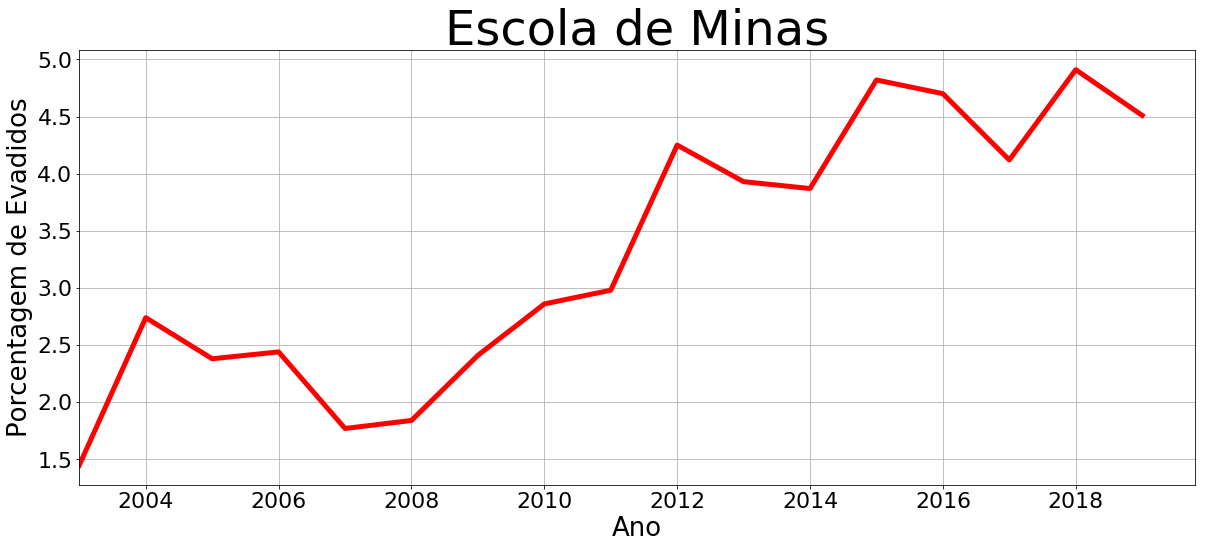

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,8))

plt.plot(tabela.iloc[:,0].values, tabela.iloc[:,4].values,color = 'red',linewidth=5)
#plt.plot(tabela.iloc[:,0].values, tabela.iloc[:,5].values,color = 'blue',linewidth=5)

plt.ylabel('Porcentagem de Evadidos',size = 26)
plt.xlabel('Ano',size = 26)

plt.xticks(size = 22)
plt.yticks(size = 22)

plt.xlim(left=2003)
plt.title('Escola de Minas', size = 48)
#plt.legend(loc = ('best'),fontsize=18)
plt.grid(True)
plt.show()

<h2> Observando a evasão de cada curso temos: <h2>

In [957]:
#Tabela base para a formulação dos gráficos e análises.
evadidos_por_data_curso = evadidos.groupby([ 'ANO', 'CURSO','TIPO_EVASAO']).EVADIDOS.sum().to_frame(name = 'Evadidos').reset_index()

evadidos_por_data_curso.tail()

,ANO,CURSO,TIPO_EVASAO,Evadidos
489,2019,PRO,DESLIGAMENTO PRAZO MÁXIMO,4
490,2019,PRO,NRM,1
491,2019,URB,CANCELAMENTO,2
492,2019,URB,DESLIGAMENTO,1
493,2019,URB,REOPCAO,1


In [958]:
#Selecione aqui qual curso da Escola de Minas 
evadidos_por_data_curso = evadidos_por_data_curso.loc[evadidos_por_data_curso['CURSO'] == 'PRO']
EM_total = EM_total.loc[EM_total['Curso'] == 'ENGENHARIA DE PRODUCAO-PRO']

In [959]:
#tabela do curso desejado
evadidos_por_data_curso = pd.DataFrame(evadidos_por_data_curso.groupby(['ANO']).Evadidos.sum())

#Juntos os bancos de dados necessários e 
matriculados_curso = pd.DataFrame(EM_total.groupby(EM_total['SemestreLetivo'].dt.year).TotalGeral.sum())
evadidos_por_data_curso['matriculados'] = matriculados_curso['TotalGeral']
evadidos_por_data_curso['Taxa de Evasao'] = (evadidos_por_data_curso['Evadidos']/evadidos_por_data_curso['matriculados'])*100
evadidos_por_data_curso = evadidos_por_data_curso.reset_index()

In [960]:
evadidos_por_data_curso.tail()

,ANO,Evadidos,matriculados,Taxa de Evasao
12,2015,32,762,4.199475
13,2016,33,757,4.359313
14,2017,29,713,4.067321
15,2018,29,712,4.073034
16,2019,11,364,3.021978


<h2>Graficos dos cursos da Escola de Minas: <h2>

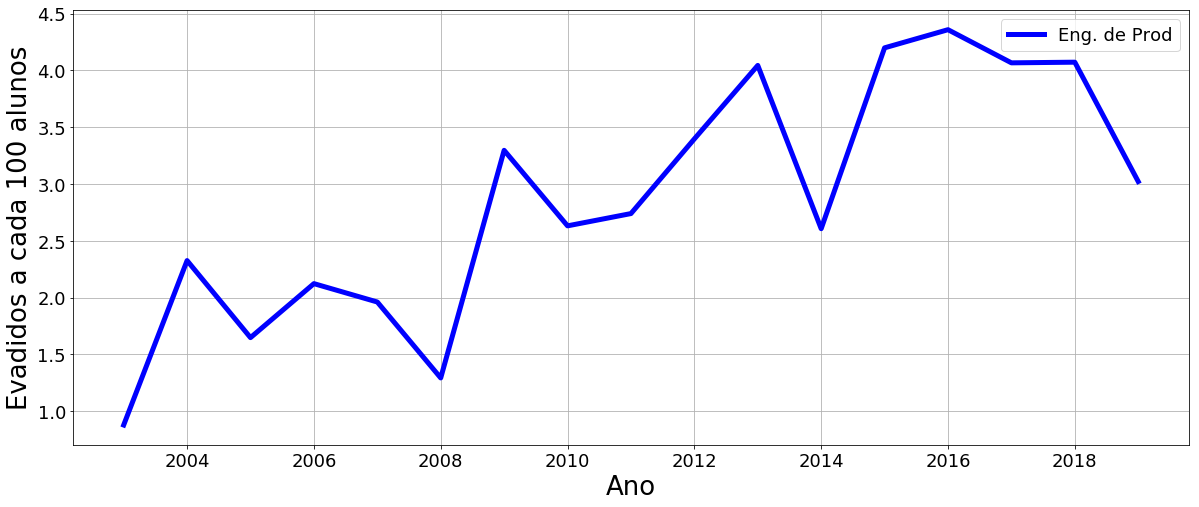

In [961]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.plot(evadidos_por_data_curso.iloc[:,0].values, evadidos_por_data_curso.iloc[:,3].values, label = 'Eng. de Prod',color = 'blue',linewidth=5)
#plt.plot(tabela_pro.iloc[:,0].values, tabela_pro.iloc[:,5].values, label = 'Eng. de Produção',color = 'blue',linewidth=5)

plt.ylabel('Evadidos a cada 100 alunos',size = 26)
plt.xlabel('Ano', size = 26)

plt.yticks(size = 18)
plt.xticks(size = 18)

#plt.title('Escola de Minas',size = 22)
plt.legend(loc = ('best'),fontsize=18)
plt.grid(True)
plt.show()